In [46]:
import numpy as np

import fasttext

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import bokeh
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

import plotly.offline as plt
import plotly.graph_objs as go
plt.init_notebook_mode(connected=True)

%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from BudgetClass import *

In [56]:
output_notebook()

Loading BokehJS ...

In [3]:
budget_2019 = Budget('data/fed_budget_19_20.txt', 'PTI 2019-2020', True)
budget_2018 = Budget('data/fed_budget_18_19.txt', 'PML-N 2018-2019', True)
budget_2017 = Budget('data/fed_budget_17_18.txt', 'PML-N 2017-2018', True)
budget_2016 = Budget('data/fed_budget_16_17.txt', 'PML-N 2016-2017', True)
budget_2015 = Budget('data/fed_budget_15_16.txt', 'PML-N 2015-2016', True)
budget_2014 = Budget('data/fed_budget_14_15.txt', 'PML-N 2014-2015', True)
budget_2013 = Budget('data/fed_budget_13_14.txt', 'PML-N 2013-2014', True)
budget_2012 = Budget('data/fed_budget_12_13.txt', 'PPP 2012-2013', True)
budget_2011 = Budget('data/fed_budget_11_12.txt', 'PPP 2011-2012', True)
budget_2010 = Budget('data/fed_budget_10_11.txt', 'PPP 2010-2011', True)
budget_2009 = Budget('data/fed_budget_09_10.txt', 'PPP 2009-2010', True)

budget_list = [budget_2019, budget_2018, budget_2017, budget_2016, budget_2015, budget_2014, budget_2013,
              budget_2012, budget_2011, budget_2010, budget_2009]

In [4]:
budget_docs = [budget.tokens for budget in budget_list]

In [5]:
budget_words = [list(budget.unique_words) for budget in budget_list]

In [6]:
all_budget_words = []
for i in range(len(budget_words)):
    for j in range(len(budget_words[i])):
        all_budget_words.append(budget_words[i][j])

In [7]:
all_budget_words = set(all_budget_words)

In [8]:
budget_docs_text = [" ".join(budget.processed_text) for budget in budget_list]

In [9]:
some_words = ['pakistan','lahore','karachi','pakistanis',
             'motorway', 'roads', 'bridge', 'expressway',
             'cotton', 'crops', 'sugarcane', 'rice',
             'solar', 'wind', 'wells', 'renewable']

In [10]:
def display_pca_scatterplot(model, algorithm, words=None, sample=0):
    if algorithm == 'fasttext':
        if words == None:
            if sample > 0:
                words = np.random.choice(list(model.words), sample)
            else:
                words = [word for word in model.words]

        word_vectors = np.array([model[w] for w in words])
        
    elif algorithm == 'word2vec':
        if words == None:
            if sample > 0:
                words = np.random.choice(list(model.wv.vocab), sample)
            else:
                words = [word for word in model.wv.vocab]
        
        word_vectors = np.array([model[w] for w in words])

    reduced = PCA().fit_transform(word_vectors)[:,:3]
    fig = plt.figure(figsize=(16,12))
    ax = Axes3D(fig)

    ax.scatter(reduced[:,0], reduced[:,1], reduced[:,2], cmap='Set1')
    for word, (x,y,z) in zip(words, reduced):
        ax.text(x, y, z, word)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()
    

In [11]:
def bokeh_visualization(model, algorithm):
    tsne = TSNE(n_components=2, n_iter=1000)
    if algorithm == 'fasttext':
        X = model.get_output_matrix()
        X_2d = tsne.fit_transform(X)
        
        coords_df = pd.DataFrame(X_2d, columns=['x','y'])
        coords_df['token'] = model.words
        
    elif algorithm == 'word2vec':
        X = model[model.wv.vocab]
        X_2d = tsne.fit_transform(X)
        
        coords_df = pd.DataFrame(X_2d, columns=['x','y'])
        coords_df['token'] = model.wv.vocab.keys()
    
    plot = figure(plot_width=800, plot_height=800)
    plot.text(x=coords_df.x, y=coords_df.y, text=coords_df.token, color="#3F7FD5")
    show(plot)

## FastText

In [12]:
fasttext_model = fasttext.train_unsupervised('data/budget_corpus.txt', dim=300, ws=20)

In [13]:
fasttext_model.get_nearest_neighbors('Mr.')

[(0.08055882900953293, 'shares'),
 (0.07343994081020355, 'invested'),
 (0.070829376578331, 'investment'),
 (0.06548749655485153, 'engine'),
 (0.060077451169490814, 'constraint'),
 (0.05950739234685898, 'procurement'),
 (0.058344557881355286, 'joint'),
 (0.053777456283569336, 'arranged'),
 (0.05088270828127861, 'initial'),
 (0.05077483505010605, 'private')]

In [14]:
fasttext_model.get_analogies("exemption","poor","rich")

[(0.8064450621604919, 'exempt'),
 (0.7761765122413635, 'consumption'),
 (0.7730417251586914, 'discriminatory'),
 (0.7649718523025513, 'exemptions'),
 (0.7504932880401611, 'slab'),
 (0.750149130821228, 'exclusion'),
 (0.7461332678794861, 'tax'),
 (0.7458335161209106, 'abolition'),
 (0.7363510727882385, 'slabs'),
 (0.7358335256576538, 'tier')]

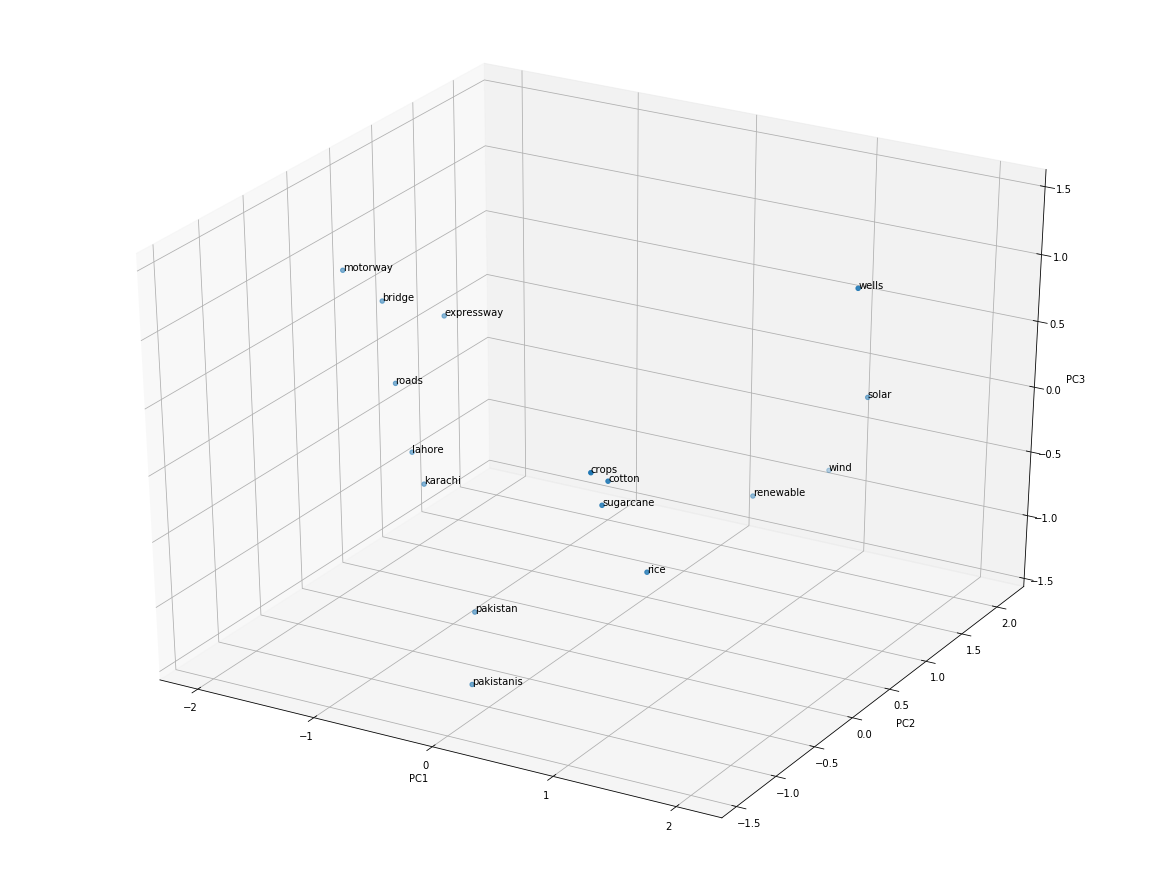

In [15]:
display_pca_scatterplot(fasttext_model, 'fasttext', some_words, sample=100)

### Bokeh visualization

In [16]:
bokeh_visualization(fasttext_model, 'fasttext')

## Word2vec

In [17]:
import gensim 
import multiprocessing
from time import time


In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [19]:
w2v_model = gensim.models.Word2Vec(budget_docs,
                                 min_count=20,
                                 window=20,
                                 size=100,
                                 negative=20,
                                 workers=cores-1)

In [20]:
t = time()

w2v_model.train(budget_docs, total_examples=w2v_model.corpus_count, epochs=200, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.28 mins


In [21]:
w2v_model.init_sims(replace=True)

In [22]:
w2v_model.wv.most_similar(positive=["technology"])

[('food', 0.33050987124443054),
 ('various', 0.3156488537788391),
 ('promote', 0.30709171295166016),
 ('view', 0.30032646656036377),
 ('efficiency', 0.2995615601539612),
 ('comprehensive', 0.2780330181121826),
 ('productivity', 0.26106739044189453),
 ('further', 0.2541179060935974),
 ('use', 0.24576213955879211),
 ('business', 0.24344351887702942)]

In [23]:
random_words = list(np.random.choice(list(w2v_model.wv.vocab), 16))


/Users/macbook/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Users/macbook/Documents/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 131 missing from current font.

/Users/macbook/Documents/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning:

Glyph 131 missing from current font.



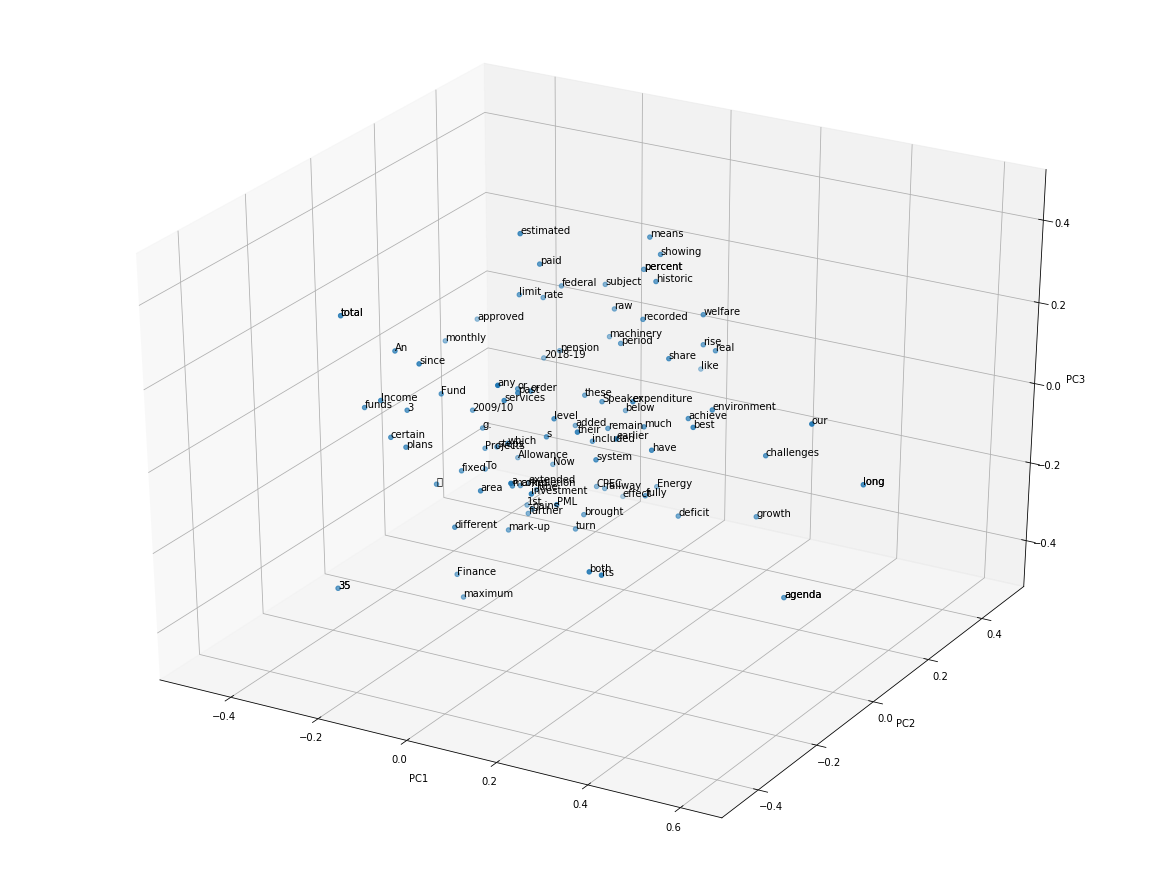

In [24]:
display_pca_scatterplot(w2v_model, 'word2vec', sample=100)

### Bokeh visualization

In [25]:
bokeh_visualization(w2v_model, "word2vec")

/Users/macbook/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



## Document Similarity

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = budget_docs_text
tfidf = TfidfVectorizer().fit_transform(documents)
# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf * tfidf.T

In [27]:
arr = pairwise_similarity.toarray()
np.fill_diagonal(arr, np.nan)

In [28]:
def get_most_similar_doc(input_idx, budget_list):
    input_doc = input_idx
    result_idx = np.nanargmax(arr[input_doc])
    print(budget_list[input_doc].name)
    print(summarize_text(budget_list[input_doc].text), "\n")
    print("\n","="*40,"\n")
    print(budget_list[result_idx].name, "\n")
    print(summarize_text(budget_list[result_idx].text))
    print("\n")

In [29]:
get_most_similar_doc(3,budget_list)

PML-N 2016-2017
water sector, where we are investing Rs.32 billion for projects in various parts
encourage new investment in textile sector to increase exports;
ingredients are chargeable to sales tax at reduced rate of 7%.
This 7% sales tax rate is proposed to be abolished.
100% new equity, tax credit on BMR is allowable at the rate of
4) Tax Credit for Establishing New Industry: Till 30 June 2016,
This tax credit is allowable for five years from start of
custom duty on the following items are proposed to be increased
the tax relief and growth measures that have been proposed for the different
are proposed to be introduced in the current Budget starting with income tax
Rationalizing Corporate Tax Rate- As per government policy and in
order to encourage corporatization, corporate tax rates are being reduced by
organized sector tax, credit is proposed to be made available for 2 years
Act 2015, Minimum Tax at the rate of 8% was levied on corporate service
allowed a reduced tax rate of 2%

## Doc2vec

In [30]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [31]:
docs = [" ".join(budget.processed_text) for budget in budget_list]

In [32]:
tagged_data = [TaggedDocument(words=nltk.word_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(docs)]

In [33]:
max_epochs = 500
vec_size = 128
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/Users/macbook/Documents/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

/Users/macbook/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



Model Saved


In [34]:
similar_doc = model.docvecs.most_similar('0')
print(similar_doc)

[('3', 0.9883872866630554), ('2', 0.9868344068527222), ('1', 0.9848231673240662), ('6', 0.9839600920677185), ('4', 0.9808510541915894), ('8', 0.9796415567398071), ('7', 0.9793158769607544), ('5', 0.978762149810791), ('10', 0.976782500743866), ('9', 0.971251368522644)]


## Pretrained Models

In [35]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [36]:
pretrained = load_vectors("/Users/macbook/Documents/pretrained/wiki-news-300d-1M.vec")

In [37]:
all_budget_words = list(all_budget_words)

In [38]:
pretrained_vecs = []
for word in all_budget_words:
    if word in pretrained:
        vector = np.array([i for i in pretrained[word]])
        pretrained_vecs.append(vector)
    else:
        pretrained_vecs.append(fasttext_model[word])

In [39]:
pretrained_vecs = np.array(pretrained_vecs)

In [43]:
random_sample = np.random.randint(1, len(pretrained_vecs), 500)
random_vectors = pretrained_vecs[list(random_sample)]
random_words = np.array(all_budget_words)[list(random_sample)]

In [41]:
tsne = TSNE(n_components=2, n_iter=1000)
X = list(pretrained_vecs)[1:]
X_2d = tsne.fit_transform(X)

coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = all_budget_words[1:]

plot = figure(plot_width=800, plot_height=800)
plot.text(x=coords_df.x, y=coords_df.y, text=coords_df.token, color="#3F7FD5")
show(plot)

In [52]:
x = np.linspace(0, 4*np.pi, 200)
y = np.sin(x)

In [57]:
#tsne = TSNE(n_components=2, n_iter=1000)
random_sample = np.random.randint(0,len(pretrained_vecs)-1,2000)
X_sample = list(random_vectors)
X_2d_sample = tsne.fit_transform(X_sample)

coords_df_sample = pd.DataFrame(X_2d_sample, columns=['x','y'])
coords_df_sample['token'] = random_words


plot_sample = figure(plot_width=800, plot_height=800)
plot_sample.text(x=coords_df_sample.x, y=coords_df_sample.y, text=coords_df_sample.token, color="#3F7FD5")
show(plot_sample)